In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import urlopen
from bs4 import BeautifulSoup
from tqdm import tqdm
import codecs
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
html = urlopen("http://craftcans.com/db.php?search=all&sort=beerid&ord=desc&view=text")
html_soup = BeautifulSoup(html, 'html.parser')

In [3]:
rows = html_soup.findAll('tr')

In [4]:
print len(rows)

2439


In [5]:
beers = []
for row in rows:
    row.encode('utf-8')
    entries = row.findAll('td')
    if len(entries) == 8:
        id = entries[0].text
        id = id[0:len(id)-1]
        try:
            beer_entry = {
                "id": int(id),
                "name": entries[1].text,
                "brewery_name": entries[2].text,
                "brewery_location": entries[3].text,
                "style": entries[4].text,
                "size": entries[5].text,
                "abv": entries[6].text,    
                "ibu": entries[7].text
            }
            beers.append(beer_entry)
        except ValueError:
            print 'ruh-roh'

ruh-roh


In [15]:
craft_cans = pd.DataFrame(data=beers)
craft_cans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 8 columns):
abv                 2424 non-null object
brewery_location    2424 non-null object
brewery_name        2424 non-null object
ibu                 2424 non-null object
id                  2424 non-null int64
name                2424 non-null object
size                2424 non-null object
style               2424 non-null object
dtypes: int64(1), object(7)
memory usage: 151.6+ KB


In [16]:
craft_cans.describe(include='all')

,abv,brewery_location,brewery_name,ibu,id,name,size,style
count,2424,2424,2424,2424,2424.000000,2424,2424,2424
unique,75,404,554,108,NaN,2318,19,100
top,5.0%,"Grand Rapids, MI",Brewery Vivant,N/A,NaN,Nonstop Hef Hop,12 oz.,American IPA
freq,221,66,62,1010,NaN,12,1482,426
mean,NaN,NaN,NaN,NaN,1438.483498,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,756.488496,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,813.750000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1460.500000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2086.250000,NaN,NaN,NaN


In [17]:
dropnas = craft_cans.replace('N/A',np.nan).dropna().copy()
dropnas.ibu = dropnas.ibu.map(float)
style_means = dict(dropnas.groupby('style').ibu.mean())

ibus = []
for i, ibu in enumerate(craft_cans.ibu):
    if ibu == 'N/A':
        try:
            ibus.append(float(style_means[craft_cans['style'].iloc[i]]))
        except KeyError:
            ibus.append(0.)
    else:
        ibus.append(float(ibu))
craft_cans['ibu_clean'] = ibus

In [18]:
craft_cans.abv.value_counts()

5.0%     221
5.5%     159
6.0%     125
6.5%     125
5.2%     107
7.0%      92
4.5%      89
4.8%      72
5.8%      67
5.6%      66
???       62
5.1%      62
6.2%      60
5.3%      60
4.9%      59
8.0%      58
4.7%      57
5.7%      53
6.8%      52
5.4%      50
7.5%      43
4.2%      38
6.3%      38
4.0%      38
7.2%      37
9.9%      35
5.9%      34
4.6%      32
6.9%      31
8.5%      26
        ... 
9.5%       9
4.1%       9
7.4%       9
8.3%       8
7.9%       7
3.5%       6
3.8%       6
8.8%       6
9.6%       5
9.7%       5
9.3%       5
7.6%       5
8.6%       4
8.1%       4
3.7%       4
8.4%       3
9.8%       3
3.2%       3
9.1%       3
2.7%       2
8.9%       2
12.0%      1
12.8%      1
0.1%       1
2.8%       1
9.4%       1
3.4%       1
10.0%      1
12.5%      1
10.4%      1
Name: abv, Length: 75, dtype: int64

In [28]:
craft_cans = craft_cans[(craft_cans.abv != '???')].copy()

states = []
for location in craft_cans.brewery_location:
    state = location.split(', ')[1]
    states.append(state)
craft_cans['state'] = states

In [31]:
craft_cans.state.value_counts()
craft_cans = pd.concat([craft_cans, pd.get_dummies(craft_cans.state, prefix='state_')])

In [29]:
abv_float = [float(x.replace('%','')) for x in craft_cans.abv]
craft_cans['abv_clean'] = abv_float

In [ ]:
craft_cans.to_csv('./data/beers.csv',encoding='utf-8')

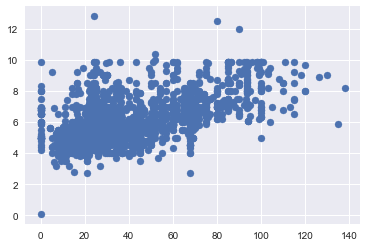

In [142]:
plt.scatter(x=craft_cans.ibu_clean, y=craft_cans.abv_clean);

In [137]:
craft_cans.dtypes

abv                  object
brewery_location     object
brewery_name         object
ibu                  object
id                    int64
name                 object
size                 object
style                object
ibu_clean           float64
abv_clean           float64
dtype: object

In [3]:
craft_cans = pd.read_csv('./data/beers.csv',index_col=0)
craft_cans.head()

,abv,brewery_location,brewery_name,ibu,id,name,size,style,ibu_clean,abv_clean,state
0,5.0%,"Chandler, AZ",SanTan Brewing Company,20.0,2707,Mr. Pineapple,12 oz.,Wheat Ale,20.000000,5.0,AZ
1,8.2%,"Cincinnati, OH",Christian Moerlein Brewing Company,70.0,2706,Handle Bar (Current),12 oz.,American Stout,70.000000,8.2,OH
2,5.0%,"Forest, VA",Apocalypse Ale Works,18.0,2705,Golden Censer,12 oz.,Wheat Ale,18.000000,5.0,VA
3,6.2%,"Manassas, VA",Heritage Brewing Company,NaN,2704,Freedom Isn't Free,12 oz.,American IPA,67.634551,6.2,VA
4,7.4%,"Manassas, VA",Heritage Brewing Company,115.0,2703,Kings Mountain,12 oz.,Scottish Ale,115.000000,7.4,VA


In [4]:
header = {'x-api-key':'8BhI6I8moq7tBc75pyNeb63FgcT3sHlI8CiMaIHF'}

all_beers = []

for beer in tqdm(craft_cans.name):
    #print beer
    ind = "query {\n beerSearch(query:" + "\"" + beer + "\") {\n items {\n id\n name\n abv\n isRetired\n styleScore\n overallScore\n averageRating\n ratingCount\n style {\n id\n name\n parent {\n id\n name\n}\n}\n brewer {\n id\n name\n city\n state {\n id\n name\n}\n score\n}\n}\n totalCount\n last\n}\n}"
    data = {"query":ind}
    r = requests.post('https://api.r8.beer/v1/api/graphql', data=data, headers=header)
    response = r.json()
    try:
        try:
            name = str(response['data']['beerSearch']['items'][0]['name'])
        except:
            name = 'N/A'
        try:
            style = str(response['data']['beerSearch']['items'][0]['style']['name'])
        except:
            style = 'N/A'
        try:
            parent_style = str(response['data']['beerSearch']['items'][0]['style']['parent']['name'])
        except:
            parent_style = 'N/A'
        try:
            overall_score = response['data']['beerSearch']['items'][0]['overallScore']
        except:
            overall_score = np.nan
        try:
            avg_rating = response['data']['beerSearch']['items'][0]['averageRating']
        except:
            avg_rating = np.nan
        this_beer = [name,style,parent_style,overall_score,avg_rating]
        all_beers.append(this_beer)
    except:
        pass
        #print "Skipping this beer: ", beer
    
rating_cols = ['r8_beer_name','r8_beer_style','r8_beer_parent_style','r8_beer_overall_score','r8_beer_avg_rating']
beer_ratings = pd.DataFrame(data=np.array(all_beers), columns=rating_cols)

beer_ratings.head()
    

100%|██████████| 2362/2362 [23:49<00:00,  1.60it/s]


,r8_beer_name,r8_beer_style,r8_beer_parent_style,r8_beer_overall_score,r8_beer_avg_rating
0,SanTan Mr. Pineapple,Wheat Ale,Wheat Beer,52.0589,3.21585
1,N/A,N/A,N/A,NaN,NaN
2,Apocalypse Ale Works Golden Censer,Wheat Ale,Wheat Beer,48.2978,3.18732
3,N/A,India Pale Ale (IPA),Anglo-American Ales,36.8753,3.01639
4,Heritage Kings Mountain,Scotch Ale,Anglo-American Ales,49.6827,3.20731


In [10]:
rated_beers = pd.concat([craft_cans,beer_ratings],axis=1)
rated_beers.r8_beer_overall_score = rated_beers.r8_beer_overall_score.astype(float)
rated_beers.r8_beer_avg_rating = rated_beers.r8_beer_avg_rating.astype(float)

In [6]:
rated_beers.to_csv('./data/beers_w_ratings.csv')

# Analysis of Quality by State (Geographic Region)
---
This section will consider the relationship between brewery geographic location and quality, as well as some analysis of the relationship between beer metrics and beer quality grouped by state.

In [3]:
rated_beers = pd.read_csv('./data/beers_w_ratings.csv',index_col=0)

In [4]:
state_avg_scores = pd.DataFrame(rated_beers.groupby('state',sort=True).r8_beer_overall_score.mean())
state_avg_ratings = pd.DataFrame(rated_beers.groupby('state',sort=True).r8_beer_avg_rating.mean())

state_avg_ratings.head()

,r8_beer_avg_rating
state,
AK,3.280919
AL,3.258320
AR,3.130284
AZ,2.951510
CA,3.220200


In [5]:
state_avgs = state_avg_scores.merge(state_avg_ratings,left_index=True,right_index=True)
state_avgs.head()

,r8_beer_overall_score,r8_beer_avg_rating
state,,
AK,78.157116,3.280919
AL,61.157913,3.258320
AR,50.618308,3.130284
AZ,52.377481,2.951510
CA,64.051661,3.220200


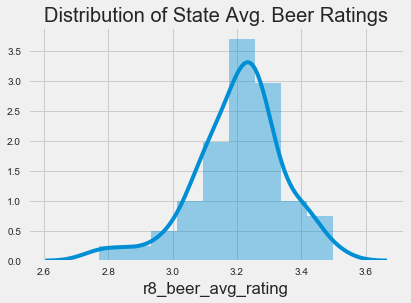

In [6]:
sns.distplot((state_avgs.r8_beer_avg_rating.dropna()));
plt.title('Distribution of State Avg. Beer Ratings');

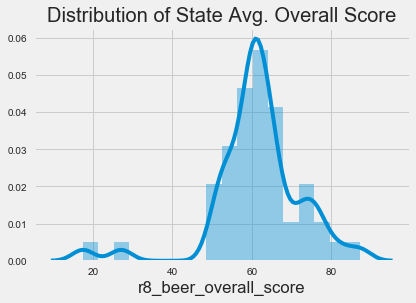

In [7]:
sns.distplot((state_avgs.r8_beer_overall_score.dropna()));
plt.title('Distribution of State Avg. Overall Score');

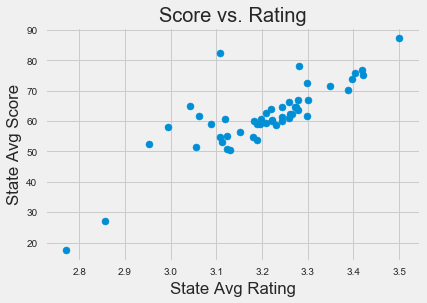

In [8]:
plt.scatter(x=state_avgs.r8_beer_avg_rating, y=state_avgs.r8_beer_overall_score);
plt.title('Score vs. Rating');
plt.xlabel('State Avg Rating');
plt.ylabel('State Avg Score');

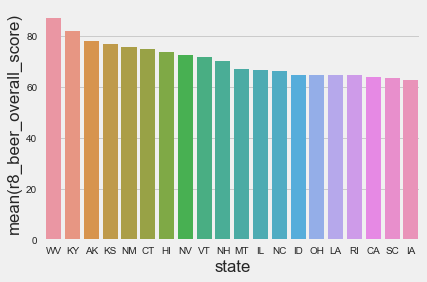

In [14]:
top_20_scores = state_avgs.sort_values(by='r8_beer_overall_score', ascending=False).r8_beer_overall_score.iloc[0:20]
sns.barplot(x=top_20_scores.index,y=top_20_scores);


# Correlation in Beer Data

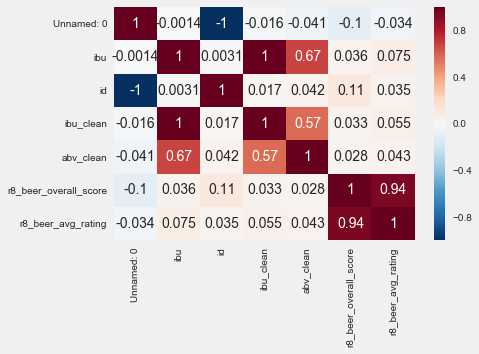

In [18]:
sns.heatmap(rated_beers.corr(),annot=True);